 #  <font color='Green'>Modeling</font> 
 # <font color='Green'>--------------</font> 
 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [3]:
Y_Train = pd.read_csv('/content/drive/MyDrive/Y_Train.csv')
Y_Train = Y_Train['Y_trend']

Y_Test  = pd.read_csv('/content/drive/MyDrive/Y_Test.csv')
Y_Test = Y_Test['Y_trend']

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

def calc_confusion_matrix_n_f1_score(y,y_pred):
    F1_Score = f1_score(y, y_pred, average='macro')
    conf_matrix = confusion_matrix(y, y_pred)
    details = ["True Negative","False Positive","False Negative","True Positive"]
    confusion_details = conf_matrix.flatten()
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(details,confusion_details)]
    labels = np.asarray(labels).reshape(2,2)
    return conf_matrix,labels,F1_Score

 #### <font size= 4, color='red'>Random Model</font> 

In [ ]:
train_probs = np.random.uniform(0,1,len(Y_Train))
test_probs  = np.random.uniform(0,1,len(Y_Test))
train_data_predictions = []
test_data_predictions = []

for p in train_probs:
    if p>0.5:
        train_data_predictions.append(1)
    else:
        train_data_predictions.append(0)

for p in test_probs:
    if p>0.5:
        test_data_predictions.append(1)
    else:
        test_data_predictions.append(0)

train_data_predictions = np.array(train_data_predictions)
test_data_predictions = np.array(test_data_predictions)

from sklearn.metrics import accuracy_score
print("Training Data Accuracy : "+str(np.round((accuracy_score(Y_Train,train_data_predictions)*100),2))+"%")
print("Test Data Accuracy : " +str(np.round((accuracy_score(Y_Test,test_data_predictions)*100),2))+"%")


Training Data Accuracy : 48.85%
Test Data Accuracy : 51.13%


************************************
F1_Score of training data :  0.489

F1_Score of test data :  0.51

************************************



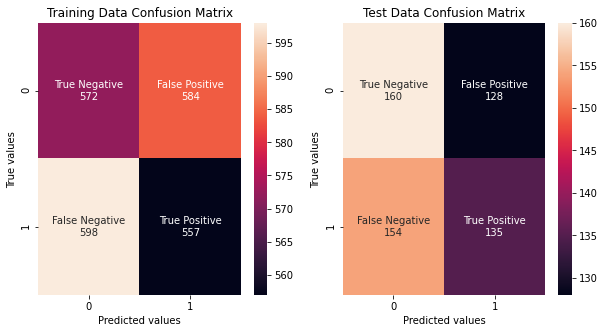

In [ ]:
c_m,l,f_1 = calc_confusion_matrix_n_f1_score(Y_Train,train_data_predictions)
print("*"*36)
print("F1_Score of training data : ",np.round(f_1,3))
print()
c_m_2,l_2,f_1_2 = calc_confusion_matrix_n_f1_score(Y_Test,test_data_predictions)
print("F1_Score of test data : ",np.round(f_1_2,3))
print()
print("*"*36)
print()

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot()
plt.title("Training Data Confusion Matrix")
sns.heatmap(c_m,annot = l,fmt='')
plt.xlabel("Predicted values")
plt.ylabel("True values")

plt.subplot(1, 2, 2)
plt.plot()
plt.title("Test Data Confusion Matrix")
sns.heatmap(c_m_2,annot = l_2,fmt='')
plt.xlabel("Predicted values")
plt.ylabel("True values")

plt.show()

<font size=3><b>Since the data is perfectly balanced,Random Model is giving almost 50% accuracy

 #### <font size= 4, color='red'>Logitsic regression Model </font> 

In [35]:
X_Train_Log_Reg = pd.read_csv('/content/drive/MyDrive/train_data_log_reg.csv')
X_Test_Log_Reg  = pd.read_csv('/content/drive/MyDrive/test_data_log_reg.csv')
X_Train_Log_Reg = X_Train_Log_Reg.set_index('Date')
X_Test_Log_Reg  = X_Test_Log_Reg.set_index('Date')

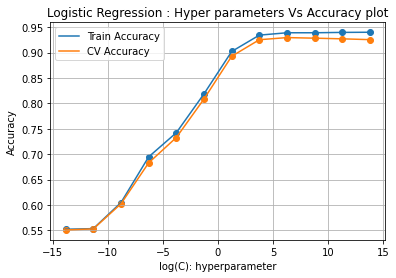

In [36]:
log_reg_model = LogisticRegression(max_iter=3000)
params={"C":np.logspace(-6,6,12)}

CV = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36)
log_reg_grid_search_cv = GridSearchCV(estimator=log_reg_model,
                                      param_grid=params,cv=CV,
                                      n_jobs=-1, scoring='accuracy',return_train_score=True
                                      )
log_reg_grid_search_cv.fit(X_Train_Log_Reg, Y_Train)

results = pd.DataFrame.from_dict(log_reg_grid_search_cv.cv_results_)
results = results.sort_values(['param_C'])
#print(results['param_alpha'])

train_acc  = results['mean_train_score']
cv_acc     = results['mean_test_score'] 
C_vals =  results['param_C']
C_vals =  [ math.log(c) for c in C_vals]

plt.plot(C_vals, train_acc, label='Train Accuracy')
plt.plot(C_vals, cv_acc, label='CV Accuracy')
plt.scatter(C_vals, train_acc)
plt.scatter(C_vals, cv_acc)


plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("Accuracy")
plt.title("Logistic Regression : Hyper parameters Vs Accuracy plot")
plt.grid()
plt.show()

In [37]:
log_reg_best_estimator = log_reg_grid_search_cv.best_estimator_
print("Best Estimator obtained after Hyper paramter tuning:")
print("*"*56)
print(log_reg_best_estimator)

calibration_clf_log_reg = CalibratedClassifierCV(log_reg_best_estimator)
calibration_clf_log_reg.fit(X_Train_Log_Reg, Y_Train)
print()

Best Estimator obtained after Hyper paramter tuning:
********************************************************
LogisticRegression(C=533.6699231206302, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=3000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)



In [38]:
# import pickle
# Pkl_Filename = '/content/drive/MyDrive/Log_Reg_Model.pkl'
# with open(Pkl_Filename, 'rb') as file:
#    Pickled_LR_Model = pickle.load(file)
# calibration_clf_log_reg = Pickled_LR_Model

In [39]:
y_train_predicted = calibration_clf_log_reg.predict(X_Train_Log_Reg)
y_test_predicted  = calibration_clf_log_reg.predict(X_Test_Log_Reg)

from sklearn.metrics import accuracy_score

print("Training Data Accuracy : "+str(np.round((accuracy_score(Y_Train,y_train_predicted)*100),2))+"%")
print("Test Data Accuracy : " +str(np.round((accuracy_score(Y_Test,y_test_predicted)*100),2))+"%")

Training Data Accuracy : 93.77%
Test Data Accuracy : 87.87%


************************************
F1_Score of training data :  0.938

F1_Score of test data :  0.878

************************************



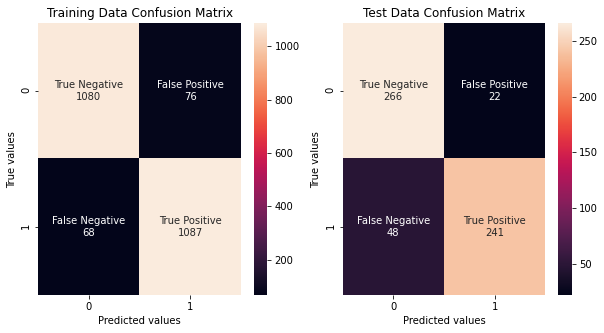

In [40]:
c_m,l,f_1 = calc_confusion_matrix_n_f1_score(Y_Train,y_train_predicted)
print("*"*36)
print("F1_Score of training data : ",np.round(f_1,3))
print()
c_m_2,l_2,f_1_2 = calc_confusion_matrix_n_f1_score(Y_Test,y_test_predicted)
print("F1_Score of test data : ",np.round(f_1_2,3))
print()
print("*"*36)
print()

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot()
plt.title("Training Data Confusion Matrix")
sns.heatmap(c_m,annot = l,fmt='')
plt.xlabel("Predicted values")
plt.ylabel("True values")

plt.subplot(1, 2, 2)
plt.plot()
plt.title("Test Data Confusion Matrix")
sns.heatmap(c_m_2,annot = l_2,fmt='')
plt.xlabel("Predicted values")
plt.ylabel("True values")

plt.show()

In [41]:
import pickle

Pkl_Filename = "/content/drive/MyDrive/Log_Reg_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(calibration_clf_log_reg, file)

 #### <font size= 4, color='red'>SVM Model</font> 

In [5]:
X_Train_svm = pd.read_csv('/content/drive/MyDrive/train_data_lin_svm.csv')
X_Test_svm  = pd.read_csv('/content/drive/MyDrive/test_data_lin_svm.csv')
X_Train_svm = X_Train_svm.set_index('Date')
X_Test_svm  = X_Test_svm.set_index('Date')

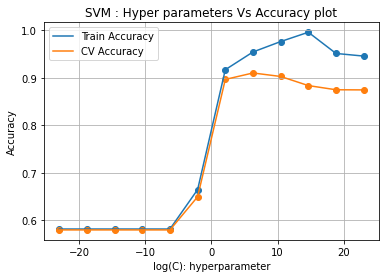

In [6]:
svm_model = SVC()
params={
        'C': np.logspace(-10,10,12)
       }

CV = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36)
svm_grid_search_cv = GridSearchCV(estimator=svm_model,
                                  param_grid=params,cv=CV,
                                  n_jobs=-1, scoring='accuracy',return_train_score=True,
                                  )
svm_grid_search_cv.fit(X_Train_svm, Y_Train)


results = pd.DataFrame.from_dict(svm_grid_search_cv.cv_results_)
results = results.sort_values(['param_C'])
#print(results['param_alpha'])

train_acc  = results['mean_train_score']
cv_acc     = results['mean_test_score'] 
C_vals =  results['param_C']
C_vals =  [ math.log(c) for c in C_vals]

plt.plot(C_vals, train_acc, label='Train Accuracy')
plt.plot(C_vals, cv_acc, label='CV Accuracy')
plt.scatter(C_vals, train_acc)
plt.scatter(C_vals, cv_acc)


plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("Accuracy")
plt.title("SVM : Hyper parameters Vs Accuracy plot")
plt.grid()
plt.show()


In [7]:
svm_best_estimator = svm_grid_search_cv.best_estimator_
print("Best Estimator obtained after Hyper paramter tuning:")
print("*"*56)
print(svm_best_estimator)

calibration_clf_svm = CalibratedClassifierCV(svm_best_estimator)
calibration_clf_svm.fit(X_Train_svm, Y_Train)
print()

Best Estimator obtained after Hyper paramter tuning:
********************************************************
SVC(C=533.6699231206302, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)



In [8]:
from sklearn.metrics import accuracy_score

# y_train_predicted = calibration_clf_svm.predict(X_Train_svm)
# y_test_predicted  = calibration_clf_svm.predict(X_Test_svm)
y_train_predicted = svm_best_estimator.predict(X_Train_svm)
y_test_predicted = svm_best_estimator.predict(X_Test_svm)


print("Training Data Accuracy : "+str(np.round((accuracy_score(Y_Train,y_train_predicted)*100),2))+"%")
print("Test Data Accuracy : " +str(np.round((accuracy_score(Y_Test,y_test_predicted)*100),2))+"%")

Training Data Accuracy : 95.37%
Test Data Accuracy : 87.69%


In [ ]:
# import pickle
# Pkl_Filename = '/content/drive/MyDrive/SVM_Model.pkl'
# with open(Pkl_Filename, 'rb') as file:
#    Pickled_LR_Model = pickle.load(file)
# calibration_clf_svm = Pickled_LR_Model

************************************
F1_Score of training data :  0.954

F1_Score of test data :  0.877

************************************



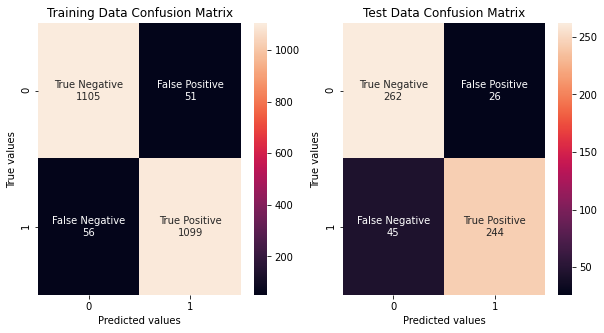

In [9]:
c_m,l,f_1 = calc_confusion_matrix_n_f1_score(Y_Train,y_train_predicted)
print("*"*36)
print("F1_Score of training data : ",np.round(f_1,3))
print()
c_m_2,l_2,f_1_2 = calc_confusion_matrix_n_f1_score(Y_Test,y_test_predicted)
print("F1_Score of test data : ",np.round(f_1_2,3))
print()
print("*"*36)
print()

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot()
plt.title("Training Data Confusion Matrix")
sns.heatmap(c_m,annot = l,fmt='')
plt.xlabel("Predicted values")
plt.ylabel("True values")

plt.subplot(1, 2, 2)
plt.plot()
plt.title("Test Data Confusion Matrix")
sns.heatmap(c_m_2,annot = l_2,fmt='')
plt.xlabel("Predicted values")
plt.ylabel("True values")

plt.show()

In [10]:
import pickle
Pkl_Filename = "/content/drive/MyDrive/SVM_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(calibration_clf_svm, file)

# with open(Pkl_Filename, 'rb') as file:  
#     Pickled_LR_Model = pickle.load(file)

 #### <font size= 4, color='red'>Decision Tree Model </font> 

In [ ]:
X_Train_dec_tree = pd.read_csv('/content/drive/MyDrive/train_data_dec_tree.csv')
X_Train_dec_tree = X_Train_dec_tree[X_Train_dec_tree.columns[0:7]]
X_Test_dec_tree  = pd.read_csv('/content/drive/MyDrive/test_data_dec_tree.csv')
X_Test_dec_tree  = X_Test_dec_tree[X_Test_dec_tree.columns[0:7]]
X_Train_dec_tree = X_Train_dec_tree.set_index('Date')
X_Test_dec_tree  = X_Test_dec_tree.set_index('Date')

In [ ]:
 list(X_Train_dec_tree.columns)

['gap_up_down_opening_T',
 'RSI-14_T',
 'RSI-14_T1',
 'Japan_gap_up_down_opening_T',
 'US_day_trend_T1',
 'EMA_sm_cross_T1']

In [ ]:
Dec_Tree_model = DecisionTreeClassifier()
params_depth = [1,3,5,6,8,9,10]
params_min_samples_split = [1,3,5,7,9,11,13,15]
params = {'max_depth':params_depth,'min_samples_split':params_min_samples_split}
CV = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36)
dec_tree_grid_search_cv = GridSearchCV(estimator=Dec_Tree_model,
                                      param_grid=params,cv=CV,
                                      n_jobs=-1, scoring='accuracy',return_train_score=True
                                      )
dec_tree_grid_search_cv.fit(X_Train_dec_tree, Y_Train)
results = pd.DataFrame.from_dict(dec_tree_grid_search_cv.cv_results_)

In [ ]:
dec_tree_best_estimator = dec_tree_grid_search_cv.best_estimator_
print("Best Estimator obtained after Hyper paramter tuning:")
print("*"*56)
print(dec_tree_best_estimator)

calibration_clf_dec_tree = CalibratedClassifierCV(dec_tree_best_estimator)
calibration_clf_dec_tree.fit(X_Train_dec_tree, Y_Train)
print()

Best Estimator obtained after Hyper paramter tuning:
********************************************************
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')



In [ ]:
import pickle
Pkl_Filename = "/content/drive/MyDrive/Dec_Tree_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(calibration_clf_dec_tree, file)

# with open(Pkl_Filename, 'rb') as file:  
#     Pickled_LR_Model = pickle.load(file)

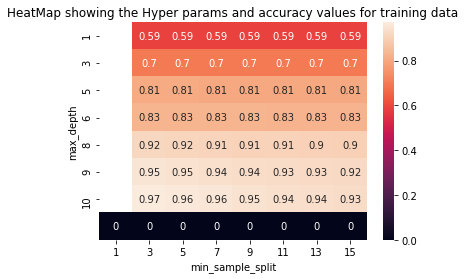

In [ ]:
import seaborn as sns

heat_map_matrix = np.zeros(64)
heat_map_matrix = heat_map_matrix.reshape(8,8)
for row in range(len(params_depth)):
    for col in range(len(params_min_samples_split)):
        heat_map_matrix[row][col]= results[ (results['param_min_samples_split'] == \
                                             params_min_samples_split[col]) & \
                                             (results['param_max_depth'] == params_depth[row])\
                                          ]['mean_train_score']
plt.figure()
sns.heatmap(heat_map_matrix,annot = True, 
        xticklabels=params_min_samples_split,
        yticklabels=params_depth)
plt.title('HeatMap showing the Hyper params and accuracy values for training data')
plt.xlabel("min_sample_split")
plt.ylabel("max_depth")
plt.show()

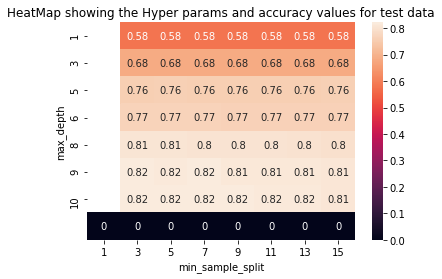

In [ ]:
heat_map_matrix = np.zeros(64)
heat_map_matrix = heat_map_matrix.reshape(8,8)

for row in range(len(params_depth)):
    for col in range(len(params_min_samples_split)):
        heat_map_matrix[row][col]= results[ (results['param_min_samples_split'] == \
                                             params_min_samples_split[col]) & \
                                             (results['param_max_depth'] == params_depth[row])\
                                          ]['mean_test_score']
        

sns.heatmap(heat_map_matrix,annot = True, 
        xticklabels=params_min_samples_split,
        yticklabels=params_depth)
plt.title('HeatMap showing the Hyper params and accuracy values for test data')
plt.xlabel("min_sample_split")
plt.ylabel("max_depth")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
y_train_predicted = calibration_clf_dec_tree.predict(X_Train_dec_tree)
y_test_predicted  = calibration_clf_dec_tree.predict(X_Test_dec_tree)

print("Training Data Accuracy : "+str(np.round((accuracy_score(Y_Train,y_train_predicted)*100),2))+"%")
print("Test Data Accuracy : " +str(np.round((accuracy_score(Y_Test,y_test_predicted)*100),2))+"%")

Training Data Accuracy : 97.88%
Test Data Accuracy : 83.36%


In [ ]:
import pickle
Pkl_Filename = '/content/drive/MyDrive/Dec_Tree_Model.pkl'
with open(Pkl_Filename, 'rb') as file:
   Pickled_LR_Model = pickle.load(file)
calibration_clf_dec_tree = Pickled_LR_Model

************************************
F1_Score of training data :  0.979

F1_Score of test data :  0.834

************************************



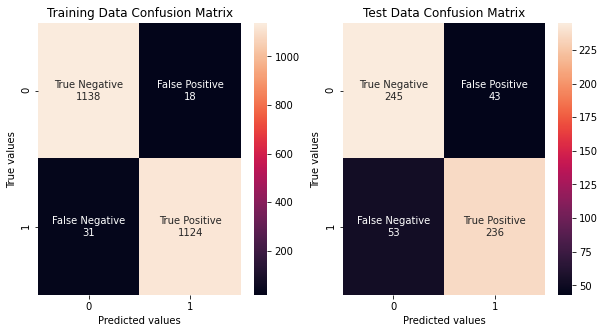

In [ ]:
c_m,l,f_1 = calc_confusion_matrix_n_f1_score(Y_Train,y_train_predicted)
print("*"*36)
print("F1_Score of training data : ",np.round(f_1,3))
print()
c_m_2,l_2,f_1_2 = calc_confusion_matrix_n_f1_score(Y_Test,y_test_predicted)
print("F1_Score of test data : ",np.round(f_1_2,3))
print()
print("*"*36)
print()

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot()
plt.title("Training Data Confusion Matrix")
sns.heatmap(c_m,annot = l,fmt='')
plt.xlabel("Predicted values")
plt.ylabel("True values")

plt.subplot(1, 2, 2)
plt.plot()
plt.title("Test Data Confusion Matrix")
sns.heatmap(c_m_2,annot = l_2,fmt='')
plt.xlabel("Predicted values")
plt.ylabel("True values")

plt.show()

 #### <font size= 4, color='red'>Random Forest Model</font> 

In [ ]:
X_Train_ran_for = pd.read_csv('/content/drive/MyDrive/train_data_ran_for.csv')
X_Train_ran_for = X_Train_ran_for[X_Train_ran_for.columns[0:7]]

X_Test_ran_for  = pd.read_csv('/content/drive/MyDrive/test_data_ran_for.csv')
X_Test_ran_for  = X_Test_ran_for[X_Test_ran_for.columns[0:7]]

X_Train_ran_for = X_Train_ran_for.set_index('Date')
X_Test_ran_for  = X_Test_ran_for.set_index('Date')

In [1]:
# list(X_Test_ran_for.columns)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
ran_for_model = RandomForestClassifier(n_jobs=-1)
params_depth = [1,3,5,7,8,10]
params_min_samples_split = [1,2,3,5,7,9]
n_estimators = [10,150,240,480,600]
params = {'max_depth':params_depth,'min_samples_split':params_min_samples_split,'n_estimators':n_estimators}
CV = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36)
ran_for_grid_search_cv = GridSearchCV(estimator=ran_for_model,
                                      param_grid=params,cv=CV,
                                      n_jobs=-1, scoring='accuracy',return_train_score=True
                                      )
ran_for_grid_search_cv.fit(X_Train_ran_for, Y_Train)
results = pd.DataFrame.from_dict(ran_for_grid_search_cv.cv_results_)

In [ ]:
ran_for_best_estimator = ran_for_grid_search_cv.best_estimator_
print("Best Estimator obtained after Hyper paramter tuning:")
print("*"*56)
print(ran_for_best_estimator)

calibration_clf_ran_for = CalibratedClassifierCV(ran_for_best_estimator)
calibration_clf_ran_for.fit(X_Train_ran_for, Y_Train)
print()

Best Estimator obtained after Hyper paramter tuning:
********************************************************
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)



In [ ]:
import pickle
Pkl_Filename = "/content/drive/MyDrive/Rand_For_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(calibration_clf_ran_for, file)


In [ ]:
# import pickle
# Pkl_Filename = "/content/drive/MyDrive/Rand_For_Model.pkl" 
# with open(Pkl_Filename, 'rb') as file:  
#      calibration_clf_ran_for = pickle.load(file)

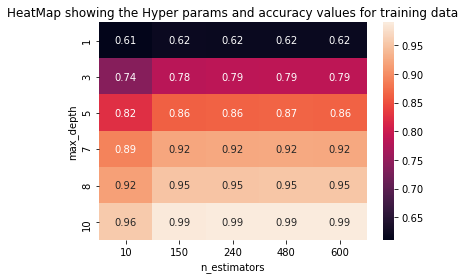

In [ ]:
import seaborn as sns

heat_map_matrix = np.zeros(30)
heat_map_matrix = heat_map_matrix.reshape(6,5)
for row in range(6):
    for col in range(5):
        heat_map_matrix[row][col]= results[ (results['param_n_estimators'] == n_estimators[col]) & \
                                             (results['param_max_depth'] == params_depth[row])\
                                          ]['mean_train_score'].max()
plt.figure()
sns.heatmap(heat_map_matrix,annot = True, 
        xticklabels=n_estimators,
        yticklabels=params_depth)
plt.title('HeatMap showing the Hyper params and accuracy values for training data')
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

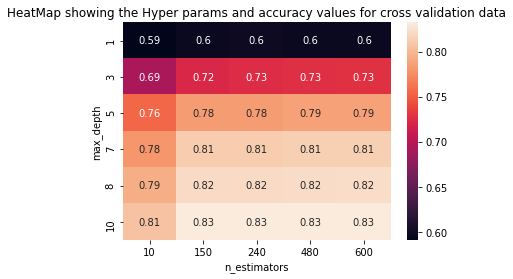

In [ ]:
heat_map_matrix = np.zeros(30)
heat_map_matrix = heat_map_matrix.reshape(6,5)
for row in range(6):
    for col in range(5):
        heat_map_matrix[row][col]= results[ (results['param_n_estimators'] == \
                                             n_estimators[col]) & \
                                             (results['param_max_depth'] == params_depth[row])\
                                          ]['mean_test_score'].max()
plt.figure()
sns.heatmap(heat_map_matrix,annot = True, 
        xticklabels=n_estimators,
        yticklabels=params_depth)
plt.title('HeatMap showing the Hyper params and accuracy values for cross validation data')
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
y_train_predicted = calibration_clf_ran_for.predict(X_Train_ran_for)
y_test_predicted  = calibration_clf_ran_for.predict(X_Test_ran_for)

print("Training Data Accuracy : "+str(np.round((accuracy_score(Y_Train,y_train_predicted)*100),2))+"%")
print("Test Data Accuracy : " +str(np.round((accuracy_score(Y_Test,y_test_predicted)*100),2))+"%")

Training Data Accuracy : 98.18%
Test Data Accuracy : 81.98%


************************************
F1_Score of training data :  0.982

F1_Score of test data :  0.819

************************************



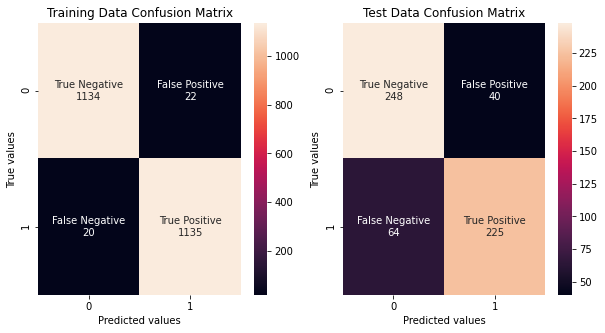

In [ ]:
c_m,l,f_1 = calc_confusion_matrix_n_f1_score(Y_Train,y_train_predicted)
print("*"*36)
print("F1_Score of training data : ",np.round(f_1,3))
print()
c_m_2,l_2,f_1_2 = calc_confusion_matrix_n_f1_score(Y_Test,y_test_predicted)
print("F1_Score of test data : ",np.round(f_1_2,3))
print()
print("*"*36)
print()

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot()
plt.title("Training Data Confusion Matrix")
sns.heatmap(c_m,annot = l,fmt='')
plt.xlabel("Predicted values")
plt.ylabel("True values")

plt.subplot(1, 2, 2)
plt.plot()
plt.title("Test Data Confusion Matrix")
sns.heatmap(c_m_2,annot = l_2,fmt='')
plt.xlabel("Predicted values")
plt.ylabel("True values")

plt.show()

 #### <font size= 4, color='red'>XG Boost Model</font> 

In [ ]:
X_Train_xgb = pd.read_csv('/content/drive/MyDrive/train_data_xgb.csv')
X_Train_xgb = X_Train_xgb[X_Train_xgb.columns[0:37]]

X_Test_xgb  = pd.read_csv('/content/drive/MyDrive/test_data__xgb.csv')
X_Test_xgb  = X_Test_xgb[X_Test_xgb.columns[0:37]]

X_Train_xgb  = X_Train_xgb.set_index('Date')
X_Test_xgb   = X_Test_xgb.set_index('Date')

In [ ]:
print(X_Train_xgb.shape)
print(X_Test_xgb.shape)

(2311, 36)
(577, 36)


In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="binary:logistic",random_state=36)

params_learning_rate = [0.0003,0.005,0.003,0.001,0.03,0.3,0.1]
params_n_estimators = [100,130,180,360,500,1000,1200]

params = {
    "learning_rate": params_learning_rate,
    "n_estimators":  params_n_estimators 
          }

CV = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36)
xgb_grid_search_cv = GridSearchCV(estimator=xgb_model,
                                  param_grid=params,cv=CV,
                                  n_jobs=-1, scoring='accuracy',
                                  return_train_score=True
                                  )

xgb_grid_search_cv.fit(X_Train_xgb, Y_Train)
results = pd.DataFrame.from_dict(xgb_grid_search_cv.cv_results_)

In [ ]:
xgb_best_estimator = xgb_grid_search_cv.best_estimator_
print("Best Estimator obtained after Hyper paramter tuning:")
print("*"*56)
print(xgb_best_estimator)

calibration_clf_xgb = CalibratedClassifierCV(xgb_best_estimator)
calibration_clf_xgb.fit(X_Train_xgb, Y_Train)
print()

Best Estimator obtained after Hyper paramter tuning:
********************************************************
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=36,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)



In [ ]:
import pickle
Pkl_Filename = "/content/drive/MyDrive/XGBoost_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(calibration_clf_xgb, file)

# with open(Pkl_Filename, 'rb') as file:  
#     Pickled_LR_Model = pickle.load(file)

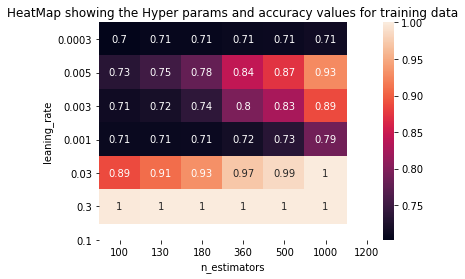

In [ ]:
import seaborn as sns

heat_map_matrix = np.zeros(36)
heat_map_matrix = heat_map_matrix.reshape(6,6)
for row in range(6):
    for col in range(6):
        heat_map_matrix[row][col]= results[ (results['param_n_estimators'] == params_n_estimators[col]) & \
                                             (results['param_learning_rate'] == params_learning_rate[row])\
                                          ]['mean_train_score']

,                                      
plt.figure()
sns.heatmap(heat_map_matrix,annot = True, 
        xticklabels=params_n_estimators,
        yticklabels=params_learning_rate)
plt.title('HeatMap showing the Hyper params and accuracy values for training data')
plt.xlabel("n_estimators")
plt.ylabel("leaning_rate")
plt.show()

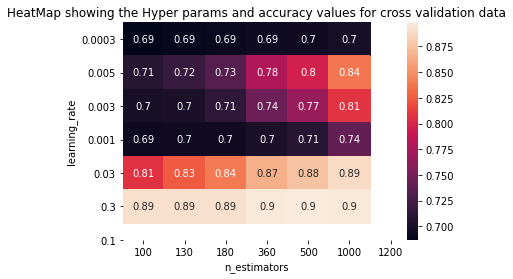

In [ ]:
import seaborn as sns

heat_map_matrix = np.zeros(36)
heat_map_matrix = heat_map_matrix.reshape(6,6)
for row in range(6):
    for col in range(6):
        heat_map_matrix[row][col]= results[ (results['param_n_estimators'] == params_n_estimators[col]) & \
                                             (results['param_learning_rate'] == params_learning_rate[row])\
                                          ]['mean_test_score']

,                                      
plt.figure()
sns.heatmap(heat_map_matrix,annot = True, 
        xticklabels=params_n_estimators,
        yticklabels=params_learning_rate)
plt.title('HeatMap showing the Hyper params and accuracy values for cross validation data')
plt.xlabel("n_estimators")
plt.ylabel("learning_rate")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
y_train_predicted = calibration_clf_xgb.predict(X_Train_xgb)
y_test_predicted  = calibration_clf_xgb.predict(X_Test_xgb)

print("Training Data Accuracy : "+str(np.round((accuracy_score(Y_Train,y_train_predicted)*100),2))+"%")
print("Test Data Accuracy : " +str(np.round((accuracy_score(Y_Test,y_test_predicted)*100),2))+"%")

Training Data Accuracy : 100.0%
Test Data Accuracy : 86.31%


In [ ]:
import pickle
Pkl_Filename = '/content/drive/MyDrive/XGBoost_Model.pkl'
with open(Pkl_Filename, 'rb') as file:
    Pickled_LR_Model = pickle.load(file)
calibration_clf_xgb = Pickled_LR_Model

************************************
F1_Score of training data :  1.0

F1_Score of test data :  0.863

************************************



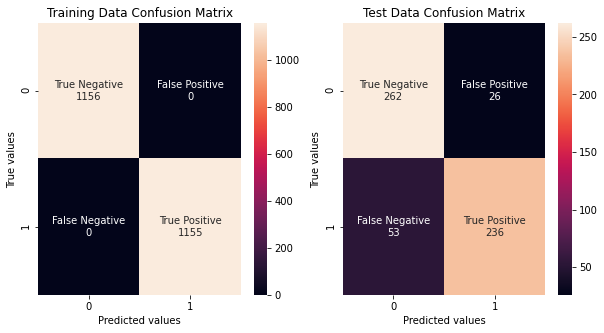

In [ ]:
c_m,l,f_1 = calc_confusion_matrix_n_f1_score(Y_Train,y_train_predicted)
print("*"*36)
print("F1_Score of training data : ",np.round(f_1,3))
print()
c_m_2,l_2,f_1_2 = calc_confusion_matrix_n_f1_score(Y_Test,y_test_predicted)
print("F1_Score of test data : ",np.round(f_1_2,3))
print()
print("*"*36)
print()

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot()
plt.title("Training Data Confusion Matrix")
sns.heatmap(c_m,annot = l,fmt='')
plt.xlabel("Predicted values")
plt.ylabel("True values")

plt.subplot(1, 2, 2)
plt.plot()
plt.title("Test Data Confusion Matrix")
sns.heatmap(c_m_2,annot = l_2,fmt='')
plt.xlabel("Predicted values")
plt.ylabel("True values")

plt.show()

 #### <font size= 4, color='red'>AdaBoost Model</font> 

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_boost_model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth =3),
                                    random_state=36)

params_learning_rate = [0.0003,0.005,0.003,0.001,0.03,0.3,0.1]
params_n_estimators = [100,130,180,360,500,1000,1200]

params = {
    "learning_rate": params_learning_rate,
    "n_estimators":  params_n_estimators 
          }

CV = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36)
ada_boost_grid_search_cv = GridSearchCV(estimator=ada_boost_model,
                                  param_grid=params,cv=CV,
                                  n_jobs=-1, scoring='accuracy',
                                  return_train_score=True
                                  )

ada_boost_grid_search_cv.fit(X_Train_xgb, Y_Train)
results = pd.DataFrame.from_dict(ada_boost_grid_search_cv.cv_results_)

In [ ]:
ada_boost_best_estimator = ada_boost_grid_search_cv.best_estimator_
print("Best Estimator obtained after Hyper paramter tuning:")
print("*"*56)
print(ada_boost_best_estimator)

calibration_clf_adb = CalibratedClassifierCV(ada_boost_best_estimator)
calibration_clf_adb.fit(X_Train_xgb, Y_Train)
print()

Best Estimator obtained after Hyper paramter tuning:
********************************************************
AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=

In [ ]:
import pickle
Pkl_Filename = "/content/drive/MyDrive/AdaBoost_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(calibration_clf_adb, file)


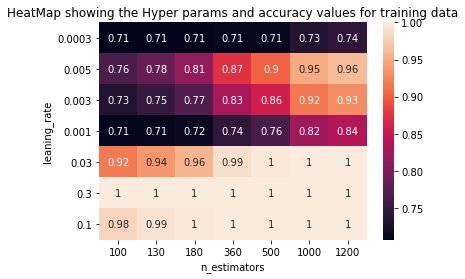

In [ ]:
import seaborn as sns

heat_map_matrix = np.zeros(49)
heat_map_matrix = heat_map_matrix.reshape(7,7)
for row in range(7):
    for col in range(7):
        heat_map_matrix[row][col]= results[ (results['param_n_estimators'] == params_n_estimators[col]) & \
                                             (results['param_learning_rate'] == params_learning_rate[row])\
                                          ]['mean_train_score']
                                    
plt.figure()
sns.heatmap(heat_map_matrix,annot = True, 
        xticklabels=params_n_estimators,
        yticklabels=params_learning_rate)
plt.title('HeatMap showing the Hyper params and accuracy values for training data')
plt.xlabel("n_estimators")
plt.ylabel("leaning_rate")
plt.show()


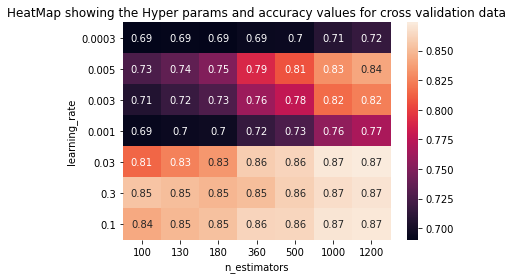

In [ ]:
import seaborn as sns

heat_map_matrix = np.zeros(49)
heat_map_matrix = heat_map_matrix.reshape(7,7)
for row in range(7):
    for col in range(7):
        heat_map_matrix[row][col]= results[ (results['param_n_estimators'] == params_n_estimators[col]) & \
                                             (results['param_learning_rate'] == params_learning_rate[row])\
                                          ]['mean_test_score']

,                                      
plt.figure()
sns.heatmap(heat_map_matrix,annot = True, 
        xticklabels=params_n_estimators,
        yticklabels=params_learning_rate)
plt.title('HeatMap showing the Hyper params and accuracy values for cross validation data')
plt.xlabel("n_estimators")
plt.ylabel("learning_rate")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
y_train_predicted = calibration_clf_adb.predict(X_Train_xgb)
y_test_predicted  = calibration_clf_adb.predict(X_Test_xgb)

print("Training Data Accuracy : "+str(np.round((accuracy_score(Y_Train,y_train_predicted)*100),2))+"%")
print("Test Data Accuracy : " +str(np.round((accuracy_score(Y_Test,y_test_predicted)*100),2))+"%")


Training Data Accuracy : 100.0%
Test Data Accuracy : 82.67%


************************************
F1_Score of training data :  1.0

F1_Score of test data :  0.826

************************************



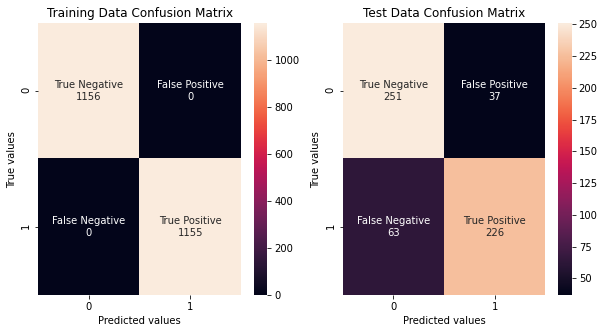

In [ ]:
c_m,l,f_1 = calc_confusion_matrix_n_f1_score(Y_Train,y_train_predicted)
print("*"*36)
print("F1_Score of training data : ",np.round(f_1,3))
print()
c_m_2,l_2,f_1_2 = calc_confusion_matrix_n_f1_score(Y_Test,y_test_predicted)
print("F1_Score of test data : ",np.round(f_1_2,3))
print()
print("*"*36)
print()

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot()
plt.title("Training Data Confusion Matrix")
sns.heatmap(c_m,annot = l,fmt='')
plt.xlabel("Predicted values")
plt.ylabel("True values")

plt.subplot(1, 2, 2)
plt.plot()
plt.title("Test Data Confusion Matrix")
sns.heatmap(c_m_2,annot = l_2,fmt='')
plt.xlabel("Predicted values")
plt.ylabel("True values")

plt.show()

 #### <font size= 4, color='red'>Stacked Model </font> 

In [11]:
import pickle

with open('/content/drive/MyDrive/Log_Reg_Model.pkl', 'rb') as file:  
     log_reg_model = pickle.load(file)
with open('/content/drive/MyDrive/SVM_Model.pkl', 'rb') as file:  
     lin_svm_model = pickle.load(file)
with open('/content/drive/MyDrive/Dec_Tree_Model.pkl', 'rb') as file:  
     dec_tree_model = pickle.load(file)
with open('/content/drive/MyDrive/Rand_For_Model.pkl', 'rb') as file:  
     rand_for_model  = pickle.load(file)
with open('/content/drive/MyDrive/XGBoost_Model.pkl', 'rb') as file:  
     xgboost_model = pickle.load(file)
with open('/content/drive/MyDrive/AdaBoost_Model.pkl', 'rb') as file:  
     adaboost_model = pickle.load(file)

train_data_base_models_predictions = pd.DataFrame()
test_data_base_models_predictions = pd.DataFrame()


X_train_log_reg = pd.read_csv('/content/drive/MyDrive/train_data_log_reg.csv')
X_test_log_reg = pd.read_csv('/content/drive/MyDrive/test_data_log_reg.csv')
train_data_base_models_predictions['Date'] = X_train_log_reg['Date']
test_data_base_models_predictions['Date'] = X_test_log_reg['Date']
X_train_log_reg = X_train_log_reg.set_index('Date')
X_test_log_reg  = X_test_log_reg.set_index('Date')
train_data_base_models_predictions['log_reg_probs']= log_reg_model.predict_proba(X_train_log_reg)[:,1]
test_data_base_models_predictions['log_reg_probs']= log_reg_model.predict_proba(X_test_log_reg)[:,1]


X_train_svm = pd.read_csv('/content/drive/MyDrive/train_data_lin_svm.csv')
X_test_svm  = pd.read_csv('/content/drive/MyDrive/test_data_lin_svm.csv')
X_train_svm = X_train_svm.set_index('Date')
X_test_svm  = X_test_svm.set_index('Date')
train_data_base_models_predictions['lin_svm_probs']= lin_svm_model.predict_proba(X_train_svm)[:,1]
test_data_base_models_predictions['lin_svm_probs']= lin_svm_model.predict_proba(X_test_svm)[:,1]

X_train_decision_tree = pd.read_csv('/content/drive/MyDrive/train_data_dec_tree.csv')
X_test_decision_tree  = pd.read_csv('/content/drive/MyDrive/test_data_dec_tree.csv')
X_train_decision_tree = X_train_decision_tree.set_index('Date')
X_test_decision_tree  = X_test_decision_tree.set_index('Date')
X_train_decision_tree = X_train_decision_tree[X_train_decision_tree.columns[0:6]]
X_test_decision_tree = X_test_decision_tree[X_test_decision_tree.columns[0:6]]
#print(X_train_decision_tree.columns)
train_data_base_models_predictions['dec_tree_probs']= dec_tree_model.predict_proba(X_train_decision_tree)[:,1]
test_data_base_models_predictions['dec_tree_probs']= dec_tree_model.predict_proba(X_test_decision_tree)[:,1]

X_train_random_forest = pd.read_csv('/content/drive/MyDrive/train_data_ran_for.csv')
X_test_random_forest = pd.read_csv('/content/drive/MyDrive/test_data_ran_for.csv')
X_train_random_forest = X_train_random_forest.set_index('Date')
X_test_random_forest  = X_test_random_forest.set_index('Date')
X_train_random_forest = X_train_random_forest[X_train_random_forest.columns[0:6]]
X_test_random_forest  = X_test_random_forest[X_test_random_forest.columns[0:6]]
#print(X_train_random_forest.columns)
train_data_base_models_predictions['rand_for_probs']= rand_for_model.predict_proba(X_train_random_forest)[:,1]
test_data_base_models_predictions['rand_for_probs']= rand_for_model.predict_proba(X_test_random_forest)[:,1]

X_train_xgboost = pd.read_csv('/content/drive/MyDrive/train_data_xgb.csv')
X_test_xgboost  = pd.read_csv('/content/drive/MyDrive/test_data__xgb.csv')
X_train_xgboost = X_train_xgboost.set_index('Date')
X_test_xgboost  = X_test_xgboost.set_index('Date')
X_train_xgboost = X_train_xgboost[X_train_xgboost.columns[0:36]]
X_test_xgboost  = X_test_xgboost[X_train_xgboost.columns[0:36]]
train_data_base_models_predictions['xgb_probs']= xgboost_model.predict_proba(X_train_xgboost)[:,1]
test_data_base_models_predictions['xgb_probs']= xgboost_model.predict_proba(X_test_xgboost)[:,1]

train_data_base_models_predictions['adaboost_probs']= adaboost_model.predict_proba(X_train_xgboost)[:,1]
test_data_base_models_predictions['adaboost_probs']= adaboost_model.predict_proba(X_test_xgboost)[:,1]

train_data_base_models_predictions = train_data_base_models_predictions.set_index('Date')
test_data_base_models_predictions  = test_data_base_models_predictions.set_index('Date')

train_data_base_models_predictions.to_csv('/content/drive/MyDrive/base_model_probabilities_train_data.csv')
test_data_base_models_predictions.to_csv('/content/drive/MyDrive/base_model_probabilities_test_data.csv')

In [12]:
X_train_probs = pd.read_csv('/content/drive/MyDrive/base_model_probabilities_train_data.csv')
X_test_probs = pd.read_csv('/content/drive/MyDrive/base_model_probabilities_test_data.csv')

In [13]:
X_train_probs = X_train_probs.set_index('Date')
X_test_probs = X_test_probs.set_index('Date')

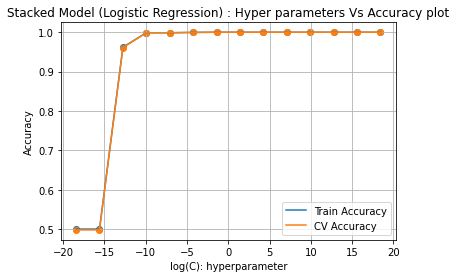

In [14]:
log_reg_model = LogisticRegression(max_iter=3000)
params={"C":np.logspace(-8,8,14)}

CV = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36)
log_reg_grid_search_cv = GridSearchCV(estimator=log_reg_model,
                                      param_grid=params,cv=CV,
                                      n_jobs=-1, scoring='accuracy',return_train_score=True
                                      )
log_reg_grid_search_cv.fit(X_train_probs, Y_Train)

results = pd.DataFrame.from_dict(log_reg_grid_search_cv.cv_results_)
results = results.sort_values(['param_C'])

train_acc  = results['mean_train_score']
cv_acc     = results['mean_test_score'] 
C_vals =  results['param_C']
C_vals =  [ math.log(c) for c in C_vals]

plt.plot(C_vals, train_acc, label='Train Accuracy')
plt.plot(C_vals, cv_acc, label='CV Accuracy')
plt.scatter(C_vals, train_acc)
plt.scatter(C_vals, cv_acc)


plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("Accuracy")
plt.title("Stacked Model (Logistic Regression) : Hyper parameters Vs Accuracy plot")
plt.grid()
plt.show()

In [15]:
best_stacked_model = log_reg_grid_search_cv.best_estimator_

In [16]:
y_train_predicted = best_stacked_model.predict(X_train_probs)
y_test_predicted  = best_stacked_model.predict(X_test_probs)

from sklearn.metrics import accuracy_score

print("Training Data Accuracy : "+str(np.round((accuracy_score(Y_Train,y_train_predicted)*100),2))+"%")
print("Test Data Accuracy : " +str(np.round((accuracy_score(Y_Test,y_test_predicted)*100),2))+"%")

Training Data Accuracy : 100.0%
Test Data Accuracy : 88.39%


************************************
F1_Score of training data :  1.0

F1_Score of test data :  0.884

************************************



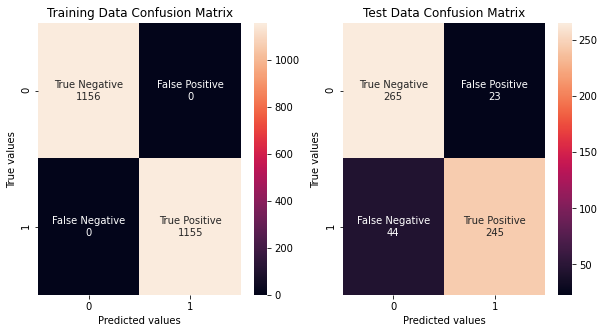

In [17]:
c_m,l,f_1 = calc_confusion_matrix_n_f1_score(Y_Train,y_train_predicted)
print("*"*36)
print("F1_Score of training data : ",np.round(f_1,3))
print()
c_m_2,l_2,f_1_2 = calc_confusion_matrix_n_f1_score(Y_Test,y_test_predicted)
print("F1_Score of test data : ",np.round(f_1_2,3))
print()
print("*"*36)
print()

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot()
plt.title("Training Data Confusion Matrix")
sns.heatmap(c_m,annot = l,fmt='')
plt.xlabel("Predicted values")
plt.ylabel("True values")

plt.subplot(1, 2, 2)
plt.plot()
plt.title("Test Data Confusion Matrix")
sns.heatmap(c_m_2,annot = l_2,fmt='')
plt.xlabel("Predicted values")
plt.ylabel("True values")

plt.show()

In [18]:
import pickle

Pkl_Filename = "/content/drive/MyDrive/Stacked_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_stacked_model, file)

# with open(Pkl_Filename, 'rb') as file:  
#     Pickled_LR_Model = pickle.load(file)

In [3]:
# ! pip install texttable
# from texttable import Texttable


In [28]:
t = Texttable()
t.add_rows([['Model','Training_Data_Accuracy','Test_Data_Accuracy','Train_Data_F1_Score','Train_Data_F1_Score'],
            ['Random Model','50.02%','49.91%','0.5','0.499'],
            ['Log_Reg','93.77%','87.87%','0.938','0.878'],
            ['SVM','93.86%','87.69%','0.954','0.877'],
            ['Dec_Trees','99.7%','80.42%','0.979','0.834'],
            ['Random Forest','100%','74.35%','0.982','0.819'],
            ['GBDT','100%','86.31%','1','0.863'],
            ['Adaboost','100','82.6','1','0.826'],
            ['Stacked Model','100%','88.39%','1','0.884']
          ])
  
print(t.draw())

+---------------+---------------+---------------+---------------+--------------+
|     Model     | Training_Data | Test_Data_Acc | Train_Data_F1 | Train_Data_F |
|               |   _Accuracy   |     uracy     |    _Score     |   1_Score    |
+===============+===============+===============+===============+==============+
| Random Model  | 50.02%        | 49.91%        | 0.500         | 0.499        |
+---------------+---------------+---------------+---------------+--------------+
| Log_Reg       | 93.77%        | 87.87%        | 0.938         | 0.878        |
+---------------+---------------+---------------+---------------+--------------+
| SVM           | 93.86%        | 87.69%        | 0.954         | 0.877        |
+---------------+---------------+---------------+---------------+--------------+
| Dec_Trees     | 99.7%         | 80.42%        | 0.979         | 0.834        |
+---------------+---------------+---------------+---------------+--------------+
| Random Forest | 100%      

<font size=3><b>Linear models are performing better than Tree based models and 

Stacked model is the best of all.